# Implementation of the *clusterITE* library

### Generate Data

In [1]:
from gen_dat import gen_data

# Generate data with 10000 points, 2 features, and 3 clusters
X, y, _, _ = gen_data(n=1000, p=2, K=3, eigen=[2, 3], verbose=True)

cluster 1: 51 points
cluster 2: 472 points
cluster 3: 477 points


In [2]:
from sklearn.model_selection import train_test_split

# train test split with 30% test data, 70% train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Minimal implementation

In [3]:
from clusterITE import *

2023-08-17 16:25:51.589736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### All parametric

1. Pick the optimal number of cluster via cross-validation

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


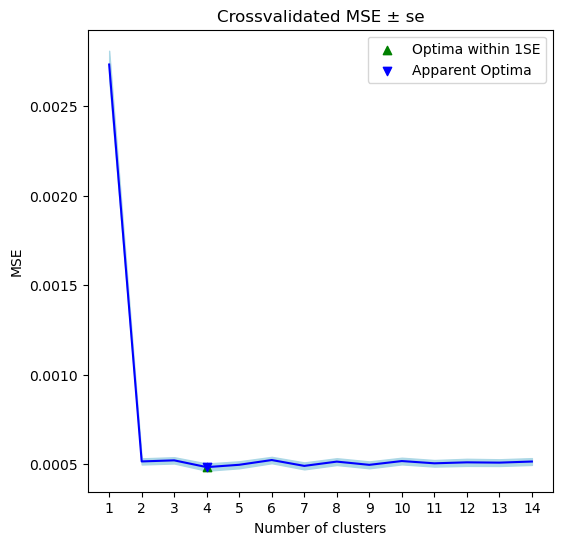

In [4]:
# Instanciate a ClusterIte model with 5 fold cross-validation
cv_model = ClusterIte_cv(nb_folds=5)

# Specify a range for the no. of clusters and fit this model to the data
cv_model.fit(X_train, y_train, cluster_range = range(1, 15))

# Plot the result
cv_model.plot()

2. Train a clusterITE model on all the data

In [5]:
# Instanciate a ClusterIte model with the optimal K estimated from cross-validation
final_model = ClusterIte(K=cv_model.best_K)

# Instanciate this model on all the training data
final_model.fit(X_train, y_train)

Converged at iteration 2 with accuracy on H 100.00%


3. Use your fitted model for cluster prediction and evaluation on unseen data

In [6]:
# Use the gating network of your trained model to predict the probabilities 
# of belonging to clusters 1,...,K for unseen observations
final_model.gate_predict(X_test)

array([[0.679206  , 0.09355596, 0.12124738, 0.10599066],
       [0.6637048 , 0.14664601, 0.11222974, 0.0774194 ],
       [0.49083975, 0.26532957, 0.14860931, 0.09522129],
       ...,
       [0.25095174, 0.494841  , 0.16371329, 0.09049399],
       [0.5388499 , 0.2459654 , 0.13305412, 0.08213063],
       [0.46969604, 0.26621264, 0.15852076, 0.10557057]], dtype=float32)

#### Non-parametric

1. Specify a model architecture

In [7]:
# For the gating network, define any Keras/Tensorflow architecture of your choice
def custom_tf_model(n_clusters):
    model = Sequential()
    ## Write your favorite architecture here...
    model.add(Dense(10, use_bias=True, activation='relu'))
    model.add(Dense(10, use_bias=True, activation='relu'))
    ## ... but make sure to finish the network like so
    model.add(Dense(n_clusters, use_bias=True, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

# For the expert networks, define any sklearn architecture of your choice
# and store both expert and gating network in a dictonary
base_learners = {'experts': RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10),
                 'gating_net': custom_tf_model}

2. Pick the optimal number of cluster via cross-validation

100%|██████████| 14/14 [03:34<00:00, 15.31s/it]


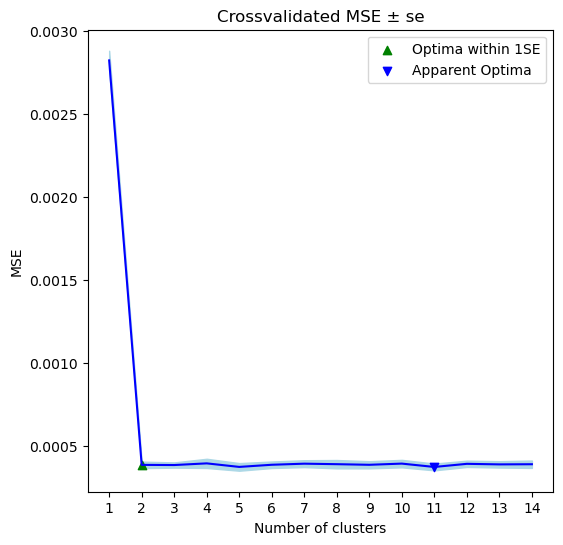

In [8]:
# Instanciate a ClusterIte model with 5 fold cross-validation
cv_model = ClusterIte_cv(nb_folds=5, **base_learners)

# Specify a range for the no. of clusters and fit this model to the data
cv_model.fit(X_train, y_train, cluster_range = range(1, 15))

# Plot the result
cv_model.plot()

3. Train a clusterITE model on all the data

In [9]:
# Instanciate a ClusterIte model with the optimal K estimated from cross-validation
final_model = ClusterIte(K=cv_model.best_K, **base_learners)

# Instanciate this model on all the training data
final_model.fit(X_train, y_train)

Converged at iteration 2 with accuracy on H 100.00%


4. Use your fitted model for cluster prediction and evaluation on unseen data

In [10]:
# Use the gating network of your trained model to predict the probabilities 
# of belonging to clusters 1,...,K for unseen observations
final_model.gate_predict(X_test)

array([[0.06200287, 0.10780065, 0.05866618, ..., 0.08824252, 0.1008172 ,
        0.09747005],
       [0.06549051, 0.1048434 , 0.04992219, ..., 0.07974798, 0.10904959,
        0.1032721 ],
       [0.07063326, 0.1005217 , 0.06128883, ..., 0.08109857, 0.10109086,
        0.10338885],
       ...,
       [0.07130864, 0.1091858 , 0.07092081, ..., 0.09050322, 0.09852473,
        0.08595672],
       [0.06762286, 0.10201272, 0.05705228, ..., 0.07892019, 0.1018734 ,
        0.10574266],
       [0.07294574, 0.09964374, 0.06364591, ..., 0.08179551, 0.10101473,
        0.10226518]], dtype=float32)

In [11]:
# Get a summary of the gating network
final_model.gating_net.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 10)                30        
                                                                 
 dense_58 (Dense)            (None, 10)                110       
                                                                 
 dense_59 (Dense)            (None, 11)                121       
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Get the weigths and biases of the gating network
final_model.gating_net.get_weights()

[array([[-0.74876785,  0.28616193,  0.01363886, -0.58881444, -0.66168374,
          0.398404  , -0.50933534, -0.32911286,  0.6589859 ,  0.3232851 ],
        [ 0.60911435,  0.4634148 ,  0.25665346,  0.29411364, -0.60610944,
          0.6448248 ,  0.15094823,  0.47643206, -0.28817087, -0.58897954]],
       dtype=float32),
 array([-0.04841355, -0.04817487,  0.04104082,  0.05650384,  0.        ,
        -0.02648179, -0.03988725, -0.04997973,  0.05278551,  0.05066153],
       dtype=float32),
 array([[-0.12939185,  0.4378202 ,  0.27117574,  0.00960719, -0.3711955 ,
         -0.04417336, -0.3103593 ,  0.15692647,  0.05962066, -0.03223783],
        [ 0.40901086, -0.10485095,  0.33142158,  0.06240531,  0.26524553,
         -0.146721  ,  0.1972842 ,  0.4014519 ,  0.22685002, -0.331357  ],
        [-0.46313277, -0.20673563,  0.38050577, -0.57566106, -0.48267692,
         -0.22519489, -0.04381787, -0.21764049,  0.25152844,  0.3585474 ],
        [-0.50936455,  0.16074616, -0.387876  ,  0.4694095 , 

In [13]:
# Evaluate the MSE of the final model on unseen data
mean_squared_error(final_model.predict(X_test), y_test)

0.00031331839962215707